## The Titanic Spaceship problem 

### Problem description
This machine learning problem involves predicting which passengers were transported to an alternate dimension during a spacetime anomaly involving the Spaceship Titanic. Given historical passenger data recovered from the damaged ship's computer system, the task is to build a classification model that accurately predicts the transport status of each passenger. 


### Packages
- **pandas, numpy**: Data manipulation and numerical operations.
- **train_test_split**: Splits dataset for training/testing.
- **LabelEncoder, StandardScaler**: Converts categorical labels, scales features.
- **RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, StackingClassifier**: Ensemble classifiers for prediction.
- **LogisticRegression**: Linear classifier.
- **matplotlib.pyplot**: Data visualization.
- **Keras (Dense, Dropout, BatchNormalization, EarlyStopping, Adam, Sequential)**: Builds and trains neural networks.
- **KNNImputer**: Imputes missing values.
- **accuracy_score, classification_report**: Evaluates classification metrics.
- **GridSearchCV**: Hyperparameter tuning.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, classification_report, make_scorer, f1_score, accuracy_score
from sklearn.svm import SVC

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Explore data
The functions here help in preparing and analyzing a dataset, which are crucial steps in solving a machine learning problem effectively:

##### 1. Balance of the target varible 
This function checks the balance of the target variable in the dataset.
 A balanced target variable is important for classifictaion machine learning models to perform well. If the target is imbalanced, it may lead to biased predictions, and additional techniques like resampling or adjusting class weights may be needed. Fortunately, this data set has a good balance of the target variable

##### 2. Check for and fill missing values
This functions checks for missing values in the dataset. It uses `isnull().sum()` to calculate the number of missing values in each column and returns only those columns with missing values greater than zero. This is useful for identifying columns that need imputation or cleaning. Missing values can significantly affect the performance of machine learning models.
- **Categorical Columns**: Fills missing values with the most common value (`mode`) for columns like `HomePlanet`, `CryoSleep`, etc.
- **Numerical Columns**: Fills missing values with the median for columns like `Age`, `RoomService`, etc.

Identifying columns with missing values allows for proper handling, ensuring the model is trained on complete and accurate data, which reduces the risk of biased or erroneous predictions. Filling categorical columns with the mode and numerical columns with the median helps preserve the distribution of data and reduces the likelihood of introducing bias. This ensures that the dataset is complete, which helps the model generalize better and produce more accurate predictions.


In [3]:
def check_target_balance(data, target_column):
    """
    Check the balance of the target variable.
    """
    target_balance = data[target_column].value_counts(normalize=True)
    return target_balance

def check_missing_values(data):
    """
    Check for missing values in the dataset.
    """
    missing_values = data.isnull().sum()
    return missing_values[missing_values > 0]

def fill_missing_values(data):
    """
    Fill missing values in the dataset.
    - Drop rows with missing values in critical columns.
    - Fill categorical columns with the mode.
    - Fill numerical columns with the median.
    """
    
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    # Fill missing categorical values with the mode
    for column in categorical_columns:
        data[column].fillna(data[column].mode()[0], inplace=True)

    # Fill missing numerical values with the median
    for column in data.select_dtypes(include=['number']).columns.tolist():
        data[column].fillna(data[column].median(), inplace=True)

    return data


### KNN imputing
Attempting to use  K-Nearest Neighbors (KNN) Imputation to fill missing values in a dataset. This method is more advanced than using mean, median, or mode.
##### How It Works
Encode Categorical Variables: Categorical columns are temporarily encoded into numbers.
KNN Imputation: KNNImputer fills missing values based on similar data points (n_neighbors=5).
Reverse Encoding: Categorical columns are decoded back to their original labels.
##### Advantages
More Accurate: Uses data similarity for better estimates compared to simple imputation.
Handles Mixed Data: Works for both categorical and numerical columns.
Maintains Relationships: Preserves relationships between features, improving model consistency.

Here is more details on KNN imputation (: , https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e.

In [4]:
def fill_missing_values_with_knn(data, categorical_columns, n_neighbors=5):
    """
    Impute missing values for both categorical and numerical variables using KNN Imputation.
    
    Parameters:
    - data: The dataframe with missing values.
    - categorical_columns: List of categorical column names.
    - n_neighbors: Number of neighbors to use for KNN imputation (default is 5).
    
    Returns:
    - data: The dataframe with imputed missing values.
    """
    # Create a copy of the data to avoid altering the original dataset
    data_copy = data.copy()

    # Temporarily encode categorical variables using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data_copy[col] = le.fit_transform(data_copy[col].astype(str))
        label_encoders[col] = le

    # Apply KNNImputer for both categorical and numerical columns
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = pd.DataFrame(knn_imputer.fit_transform(data_copy), columns=data_copy.columns)

    # Reverse the encoding for categorical variables
    for col in categorical_columns:
        imputed_data[col] = imputed_data[col].round().astype(int)
        imputed_data[col] = label_encoders[col].inverse_transform(imputed_data[col])

    return imputed_data

### Standadise data
The standardize_numerical_columns function standardizes numerical columns in a dataset using z-score normalization. This process ensures that each numerical column has a mean of 0 and a standard deviation of 1, which is beneficial for many machine learning models that perform better when features are on a similar scale.
##### How It Works
Select Numerical Columns: The function standardizes columns such as Age, RoomService, FoodCourt, etc.\
Data Copy: A copy of the original dataset is created to avoid modifying the original data.
Standard Scaling: The function uses StandardScaler from scikit-learn to transform the numerical columns to a standardized scale.
##### Advantages
Improves Model Performance: Many machine learning algorithms, such as gradient descent-based models, work better when features are on a similar scale.
Handles Outliers: Z-score normalization reduces the impact of outliers, making the model more stable.

In [5]:
def standardize_numerical_columns(data):
    """
    Standardize numerical columns in the dataset using z-score normalization.
    
    Parameters:
    - data: The dataframe containing the data.
    - numerical_columns: List of numerical column names to be standardized.
    
    Returns:
    - data: The dataframe with standardized numerical columns.
    """
    
    # Define the numerical columns that you want to standardize
    numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend']
    # Create a copy of the data to avoid altering the original dataset
    data_copy = data.copy()

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Standardize the numerical columns
    data_copy[numerical_columns] = scaler.fit_transform(data_copy[numerical_columns])

    return data_copy

### Feature Engineering
The feature_engineering function performs transformations on the dataset to create new features and enhance existing ones. Feature engineering is crucial for improving the predictive power of machine learning models.

##### Key Transformations
1. Split 'Cabin' into 'Deck', 'CabinNumber', and 'Side': The function splits the Cabin column into three new columns: Deck, CabinNumber, and Side, providing more detailed information for modeling.
2. Create 'TotalSpend' Feature: A new feature TotalSpend is created by summing up expenses from RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck. This gives a comprehensive view of a passenger's spending behavior.
3. Create 'AgeGroup' Feature: The function categorizes Age into AgeGroup with bins like Child, Teen, YoungAdult, Adult, and Senior to better capture age-based patterns.
4. Split 'Name' into 'FirstName' and 'Surname': The Name column is split into FirstName and Surname to provide granular information that may be useful for certain models.
##### Advantages
1. Enhanced Model Features: These transformations help machine learning models identify underlying relationships better by providing new and more informative features.
2. Improved Interpretability: Features like AgeGroup and TotalSpend improve interpretability by categorizing continuous data and summarizing spending behavior.

In [6]:
def feature_engineering(data):
    """
    Perform feature engineering on the dataset.
    - Split 'Cabin' into 'Deck', 'CabinNumber', and 'Side'.
    - Create 'TotalSpend' feature.
    - Create 'AgeGroup' feature.
    """
    # Split 'Cabin' into 'Deck', 'CabinNumber', and 'Side'
    data[['Deck', 'CabinNumber', 'Side']] = data['Cabin'].astype(str).str.split('/', expand=True)
    data['CabinNumber'] = pd.to_numeric(data['CabinNumber'], errors='coerce')
    data = data.drop(columns=['Cabin'])

    # Create 'TotalSpend' feature
    data['TotalSpend'] = (
        data['RoomService'] +
        data['FoodCourt'] +
        data['ShoppingMall'] +
        data['Spa'] +
        data['VRDeck']
    )
    
    # split passenger Ids
    data[['GroupID', 'IndividualID']] = data['PassengerId'].str.split('_', expand=True)
    data = data.drop(columns=['PassengerId'])

    # Create age groups
    # bins = [0, 12, 18, 35, 60, 100]
    # labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
    # data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels)
    
    # Ensure 'Name' column contains strings and handle missing values
    data['Name'] = data['Name'].astype(str).fillna('Unknown Unknown')
    
    # Split 'Name' into a list of strings
    name_split = data['Name'].str.split(' ', n=1, expand=True)  # Split only at the first space
    
    # Assign the first part as 'FirstName' and the second part as 'Surname'
    data['FirstName'] = name_split[0]
    data['Surname'] = name_split[1].fillna('Unknown')
    data = data.drop(columns=['Name'])
    return data

In [7]:
def feature_selection_with_lasso(X_train, y_train, X_test, cv=5):
    """
    Performs feature selection using Lasso regularization.
    
    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training labels.
    X_test (DataFrame): Test feature set.
    cv (int): Number of cross-validation folds for LassoCV. Default is 5.
    
    Returns:
    X_train_selected (DataFrame): Transformed training set with selected features.
    X_test_selected (DataFrame): Transformed test set with selected features.
    """
    # Use Lasso to select features
    lasso = LassoCV(cv=cv).fit(X_train, y_train)
    model = SelectFromModel(lasso, prefit=True)
    X_train_selected = model.transform(X_train)
    X_test_selected = model.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[model.get_support()]
    
    # Convert back to DataFrame
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)
    
    return X_train_selected, X_test_selected

### Categorical variables encoding
The encode_categorical_features function encodes categorical columns in the dataset using LabelEncoder. This step is essential to convert categorical data into numerical values, which are required by many machine learning models.

##### How It Works
LabelEncoder: The function uses LabelEncoder from scikit-learn to transform categorical features into numerical labels. Each unique category in a column is assigned a unique integer.
Columns Encoded: Columns like HomePlanet, CryoSleep, Destination, and others are encoded to prepare them for modeling.
##### Advantages
Model Compatibility: Many machine learning algorithms, such as decision trees and linear models, require numerical input. Encoding categorical features allows these models to effectively use the dataset.
Handles Multiple Categories: Label encoding is a straightforward way to handle multiple categorical variables without introducing high-dimensional feature sets like one-hot encoding.



In [8]:
def encode_categorical_features(data):
    """
    Encode categorical features using LabelEncoder.
    """
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object', 'category']).columns.tolist():
        data[column] = label_encoder.fit_transform(data[column].astype(str))
    
    return data

### Preprocess data 
Finally, we  perform the entire data preprocessing pipeline, preparing the dataset for machine learning using the funtions desribed above. 

##### Steps in the Preprocessing Pipeline
1. Fill Missing Values
2. Feature Engineering
3. Standardize Numerical Columns
4. Encode Categorical Variables
5. Check Target Variable Balance

In [9]:
def preprocess_data(data, target_column='Transported'):
    """
    Perform the full preprocessing pipeline on the dataset.
    """
    cc = data.select_dtypes(include=['object', 'category']).columns.tolist()
    data = fill_missing_values_with_knn(data, cc)
    data = feature_engineering(data)
    data = fill_missing_values(data)
    data = standardize_numerical_columns(data)
    data = encode_categorical_features(data)
    target_balance = check_target_balance(data, target_column)
    print("Target Balance:\n", target_balance)

    return data


### Evaluating model
The models will be evaluated as follows:

##### Classification Report: 
The classification_report() function generates metrics like precision, recall, and F1-score for each class, helping assess false positives and false negatives, especially for imbalanced datasets.
1. Precision: Measures how many predicted positives are true positives.
2. Recall: Measures how many actual positives are captured.
3. F1-score: Balances precision and recall.

##### Confusion Matrix:
This is a visualisation that helps identify which classes are being confused, making it easier to spot areas of weakness in the model.

Metrics like precision, recall, and F1-score provide insights into different types of errors, guiding improvements.Error Analysis: The confusion matrix helps understand class biases and errors, providing insights for refining the model.

In [10]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the given model by predicting on the test set and printing the classification report,
    and also visualizes the confusion matrix.

    Parameters:
    - model: The trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test set.
    """
    # Get predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Predictions
The prediction_results function processes a dataset, makes predictions using a trained model, and saves the results to a CSV file.

##### Steps

1. Load Dataset: Reads the dataset and initializes the Transported column as False.
2. Preprocess Data: Applies all preprocessing steps using preprocess_data.
3. Drop Unnecessary Columns: Keeps only the relevant input features for prediction.
4. Make Predictions: Uses the model to predict outcomes.
5. Format Predictions: Converts numerical predictions to 'True' or 'False' based on a threshold.
6. Save Results: Saves PassengerId and predictions to a CSV file.

In [11]:
def prediction_results(model, features, data_path='test.csv'):
    """
    Process the dataset, make predictions using the provided model, and save the results to a CSV file.
    
    Parameters:
    - data_path: Path to the dataset to be processed.
    - model: Trained machine learning model to use for predictions.
    - output_path: Path to save the prediction results.
    """
    # Load the dataset
    output_path=f'{type(model).__name__}_predictions.csv'
    data = pd.read_csv(data_path, dtype={'PassengerId': 'object'})
    data['Transported'] = False
    passenger_ids = data['PassengerId']
    data = preprocess_data(data)
    data = data.drop(columns=[ 'Transported'])
    data = data[features]
    predictions = model.predict(data)
    
    # Ensure predictions are a 2D array
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    
    # Convert float predictions to 'True' or 'False' if needed
    if predictions.dtype == np.float32 or predictions.dtype == np.float64:
        predictions = np.where(predictions > 0.5, 'True', 'False')
    # Create a DataFrame with PassengerId and Transported predictions
    output = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': predictions.flatten()})
    output.to_csv(output_path, index=False)

### Lets get startred !
Prepare and split the dataset for training a machine learning model.
##### Steps
1. Load Data: Loads and previews the dataset.
2. Check & Preprocess: Handles missing values, feature engineering, and encoding.
3. Split Data: Splits into features (X) and target (y) and performs a train-test split (80/20).

In [12]:
spaceship_data = pd.read_csv('train.csv', dtype={'PassengerId': 'object'})
spaceship_data.head()

check_missing_values(spaceship_data)
spaceship_data = preprocess_data(spaceship_data)

# Split the dataset into features and target
X = spaceship_data.drop(columns=[ 'Transported'])
y = spaceship_data['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test = feature_selection_with_lasso(X_train, y_train, X_test)

C:\Users\shami\AppData\Local\Temp\ipykernel_18064\2346979223.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_18064\2346979223.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

Target Balance:
 Transported
1.0    0.503624
0.0    0.496376
Name: proportion, dtype: float64


C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


# Models

### 1. Random Forrest
The first model atteted here is thet Random Forest, an ensemble learning method that combines multiple decision trees to improve prediction accuracy and control overfitting. Each tree is built on a different subset of data, and the final prediction is determined by averaging (for regression) or voting (for classification) the results from all trees. The model is well-suited for handling both classification and regression tasks and can manage high-dimensional datasets effectively.
###### 81% accuracy
##### Steps

1. Define Parameter Grid: Specifies a range of values for key hyperparameters such as n_estimators, max_depth, min_samples_split, etc., to optimize the model using GridSearchCV.
2. Set up and Run GridSearchCV: Uses GridSearchCV to find the best parameters for the Random Forest model through cross-validation (cv=3), optimizing for accuracy.
3. Evaluate Best Model: Fits the best model to the test data and evaluates it using accuracy and a classification report.
4. Feature Importance: Extracts and plots feature importance to understand the most impactful features on model predictions. This was important for me to choose the best and significant features for the other models. 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
177 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79      1082
         1.0       0.79      0.81      0.80      1092

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174



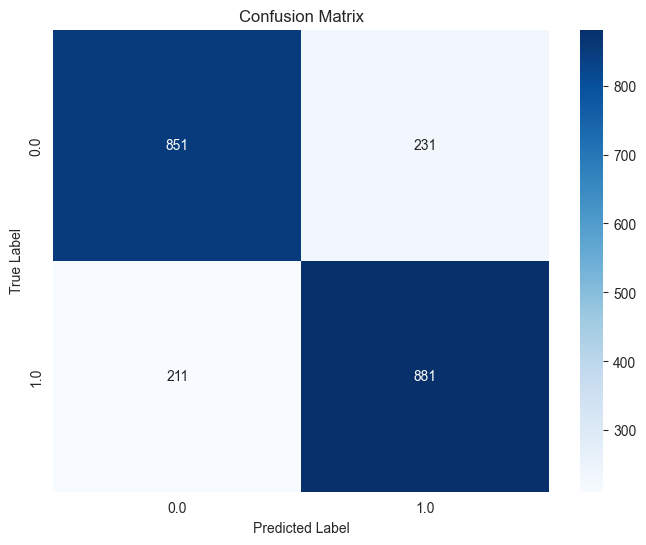

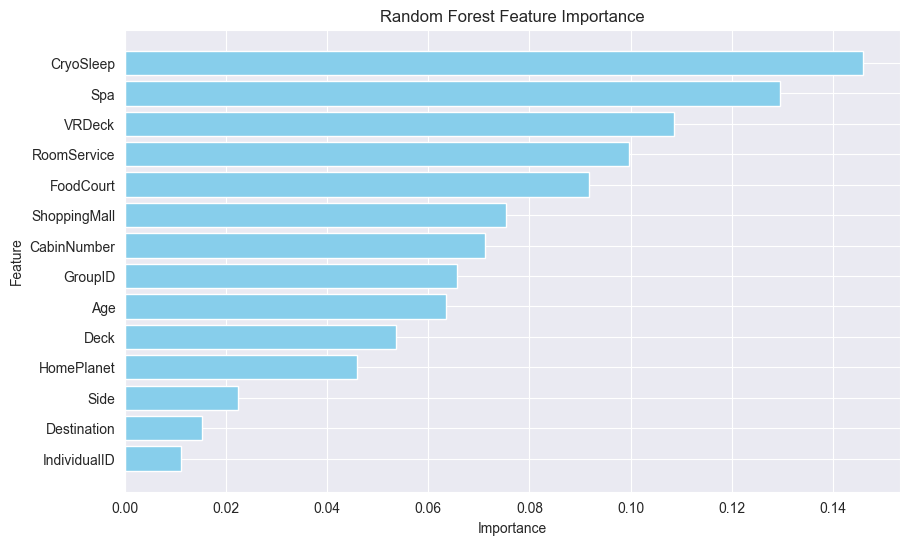

C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Target Balance:
 Transported
0.0    1.0
Name: proportion, dtype: float64


In [13]:
# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2,  scoring=scoring, refit='f1')

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
random_forrest = grid_search.best_estimator_

y_pred_best = random_forrest.predict(X_test)
evaluate_model(model = random_forrest, X_test = X_test, y_test = y_test)

# feature importance 
# Extract feature importances
importances = random_forrest.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

prediction_results(model=random_forrest, features = X_train.columns)

### 2. Ensemble methods (Stacking)
Next lets train three different machine learning models—Gradient Boosting, XGBoost, and a Stacking Classifier—to compare their performances on the given dataset.
###### improved accuracy from 80% to 80.36%
##### Models

1. Gradient Boosting: Trains a Gradient Boosting model with 100 estimators, a learning rate of 0.1, and a maximum depth of 3. The model is evaluated using accuracy and a classification report.

Gradient Boosting is an ensemble learning technique that builds multiple decision trees sequentially, with each tree trying to correct the errors of the previous one. It is effective for both classification and regression tasks

2. XGBoost: Trains an XGBoost model with similar hyperparameters as the Gradient Boosting model. The performance is also evaluated using accuracy and a classification report.
Extreme Gradient Boosting is an optimized version of Gradient Boosting that is designed for speed and performance. It uses advanced regularization techniques to reduce overfitting and is highly efficient in handling large datasets. 

3. Stacking Classifier: Combines multiple base models (Random Forest, Gradient Boosting, XGBoost) using Stacking. The final estimator is a Logistic Regression model that learns from the predictions of the base models.

Stacking is an ensemble learning technique that combines multiple base models to improve overall predictive performance. The idea is to use the predictions of several different models (e.g., Random Forest, Gradient Boosting, XGBoost) as input features for a final estimator (in this case, a Logistic Regression model). This final model learns how to best combine the outputs of the base models, often resulting in better accuracy and generalization compared to using any individual model alone. Stacking benefits from the strengths of each base model, as different algorithms can capture various aspects of the data.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.92      0.73      1082
         1.0       0.83      0.39      0.53      1092

    accuracy                           0.65      2174
   macro avg       0.71      0.65      0.63      2174
weighted avg       0.72      0.65      0.63      2174



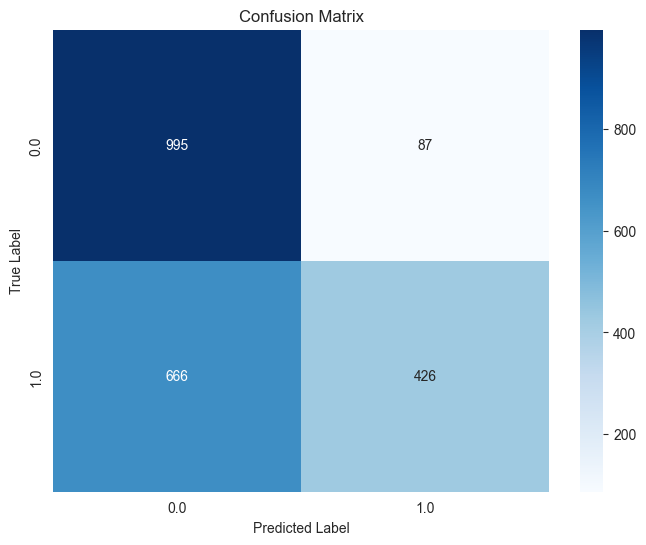

Target Balance:
 Transported
0.0    1.0
Name: proportion, dtype: float64


C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [14]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

# 4. MLPClassifier
mlp = MLPClassifier(max_iter=1000, random_state=2)
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=3, n_jobs=-1, verbose=2,  scoring=scoring, refit='f1')
grid_search_mlp.fit(X_train, y_train)
best_mlp = grid_search_mlp.best_estimator_
evaluate_model(model=best_mlp, X_test=X_test, y_test=y_test)
prediction_results(model=best_mlp, features=X_train.columns)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      1082
         1.0       0.78      0.83      0.80      1092

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174



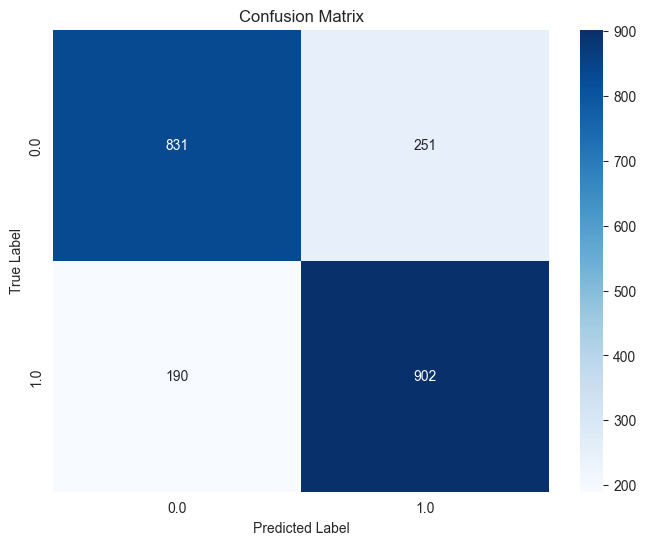

C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Target Balance:
 Transported
0.0    1.0
Name: proportion, dtype: float64
Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78      1082
         1.0       0.77      0.82      0.79      1092

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174



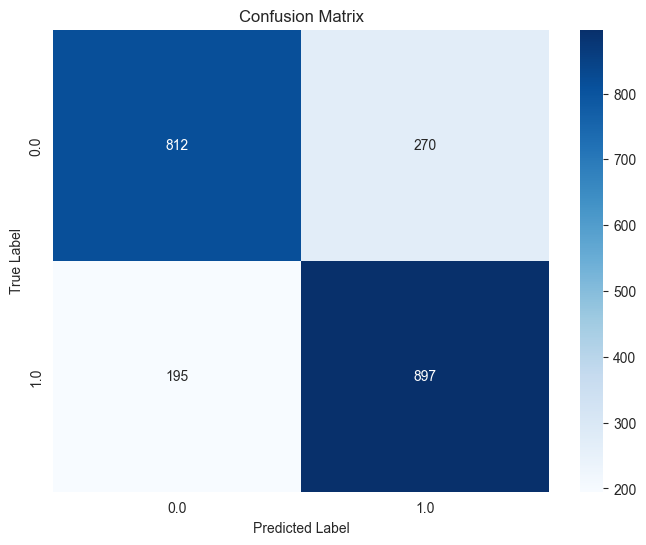

Target Balance:
 Transported
0.0    1.0
Name: proportion, dtype: float64


C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [15]:
# Hyperparameter tuning for Gradient Boosting and XGBoost
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# 1. Gradient Boosting
gb = GradientBoostingClassifier(random_state=4)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2,  scoring=scoring, refit='f1')
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_
evaluate_model(model=best_gb, X_test=X_test, y_test=y_test)
prediction_results(model=best_gb, features=X_train.columns)

# 3. AdaBoost
ab = AdaBoostClassifier(random_state=9)
grid_search_ab = GridSearchCV(estimator=ab, param_grid=param_grid_ab, cv=3, n_jobs=-1, verbose=2,  scoring=scoring, refit='f1')
grid_search_ab.fit(X_train, y_train)
best_ab = grid_search_ab.best_estimator_
evaluate_model(model=best_ab, X_test=X_test, y_test=y_test)
prediction_results(model=best_ab, features=X_train.columns)

In [ ]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=2, n_jobs=-1, verbose=2, scoring=scoring, refit='f1')
grid_search_svc.fit(X_train, y_train)
best_svc = grid_search_svc.best_estimator_
evaluate_model(model=best_svc, X_test=X_test, y_test=y_test)
prediction_results(model=best_svc, features=X_train.columns)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79      1082
         1.0       0.78      0.84      0.81      1092

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174



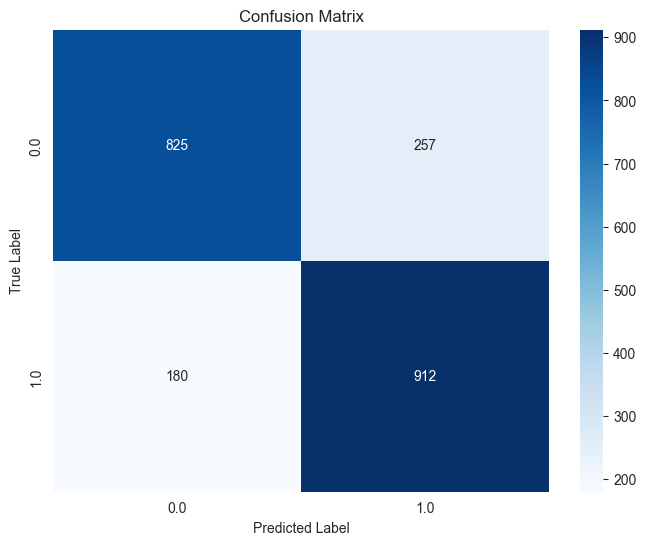

C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6072\2346979223.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Target Balance:
 Transported
0.0    1.0
Name: proportion, dtype: float64


In [16]:
# 3. Stacking Classifier with Reduced Overfitting
estimators = [
    ('rf', random_forrest),
    ('gb', best_gb),
    ('ab', best_ab),
    ('mlp', best_mlp),
    ('svc', best_svc)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression( max_iter=100000), cv=10, n_jobs=-1, passthrough=True)
stacking_model.fit(X_train, y_train)
evaluate_model(model=stacking_model, X_test=X_test, y_test=y_test)
prediction_results(model=stacking_model, features=X_train.columns)